In [2]:
!pip install torchaudio

     ---------------------------------------- 2.0/2.0 MB 3.2 MB/s eta 0:00:00


In [1]:
import os 
import matplotlib.pyplot as plt

import librosa 
import librosa.display

import IPython.display as ipd

import torch 
import torchaudio

import numpy as np

c:\users\nites\appdata\local\programs\python\python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
audio_path = "downloads/10/51833.mp3"

In [3]:
x, sr = librosa.load(audio_path, sr = 44100)

In [4]:
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


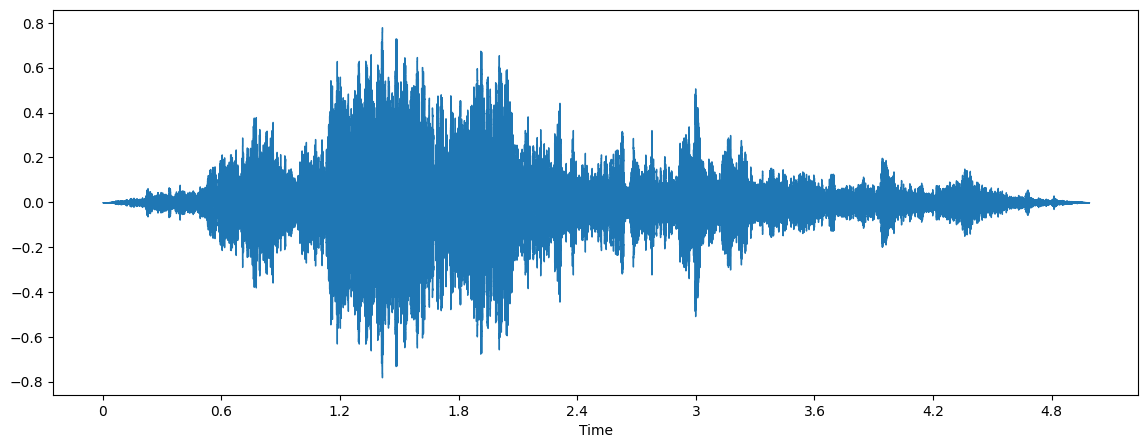

In [5]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr = sr)

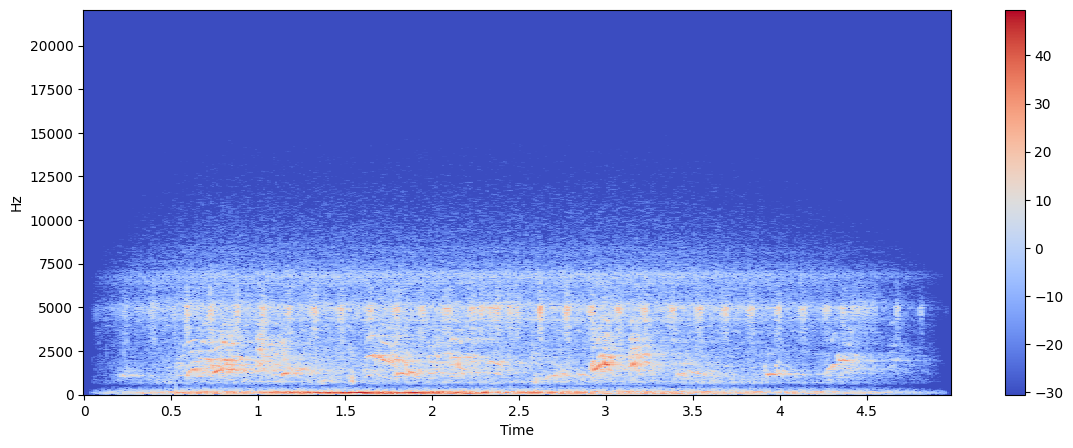

In [6]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [7]:
Xdb

array([[-30.50521 , -30.50521 , -29.336641, ..., -27.655413, -30.50521 ,
        -30.50521 ],
       [-30.50521 , -30.50521 , -29.478992, ..., -26.21498 , -30.50521 ,
        -30.50521 ],
       [-30.50521 , -30.50521 , -30.475914, ..., -19.202244, -29.318272,
        -30.50521 ],
       ...,
       [-30.50521 , -30.50521 , -30.50521 , ..., -30.50521 , -30.50521 ,
        -30.50521 ],
       [-30.50521 , -30.50521 , -30.50521 , ..., -30.50521 , -30.50521 ,
        -30.50521 ],
       [-30.50521 , -30.50521 , -30.50521 , ..., -30.50521 , -30.50521 ,
        -30.50521 ]], dtype=float32)

In [8]:
Xdb.shape

(1025, 430)

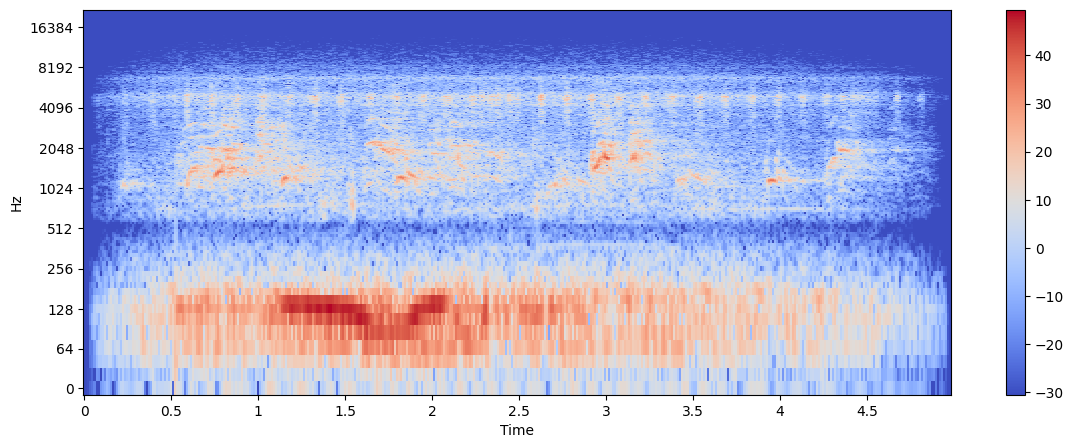

In [9]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [10]:
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

In [12]:
model = bundle.get_model().to(device)

In [13]:
waveform, sample_rate = torchaudio.load(audio_path)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [14]:
with torch.inference_mode(): 
    features, _  = model.extract_features(waveform)

In [15]:
features

[tensor([[[ 0.1624,  0.3731, -0.0985,  ...,  0.4120,  0.3173, -0.0564],
          [ 0.1066,  0.2824, -0.1172,  ..., -0.0094,  0.3354, -0.1473],
          [ 0.3378,  0.2772, -0.0176,  ...,  0.0371, -0.0045, -0.2255],
          ...,
          [ 0.1268,  0.2998,  0.0502,  ..., -0.1672,  0.1036,  0.0698],
          [ 0.1170,  0.2212, -0.1251,  ...,  0.2642, -0.1537,  0.0565],
          [-0.0667,  0.2222,  0.1040,  ...,  0.3381,  0.0855,  0.1878]]]),
 tensor([[[ 0.1222, -0.0147, -0.3205,  ...,  0.7282,  0.1174,  0.1096],
          [ 0.0533,  0.2191, -0.2017,  ...,  0.3635,  0.0815,  0.0332],
          [ 0.1651,  0.2072, -0.2540,  ...,  0.1739, -0.0310,  0.0044],
          ...,
          [-0.0139,  0.2388,  0.0976,  ...,  0.1865,  0.0661,  0.2195],
          [ 0.1369,  0.2109,  0.1094,  ...,  0.3172,  0.0696,  0.1707],
          [ 0.2075, -0.0866, -0.0307,  ...,  0.5508,  0.1060,  0.1708]]]),
 tensor([[[ 0.1085,  0.1178, -0.3105,  ...,  0.2180, -0.2490,  0.1249],
          [-0.0026,  0.2012,

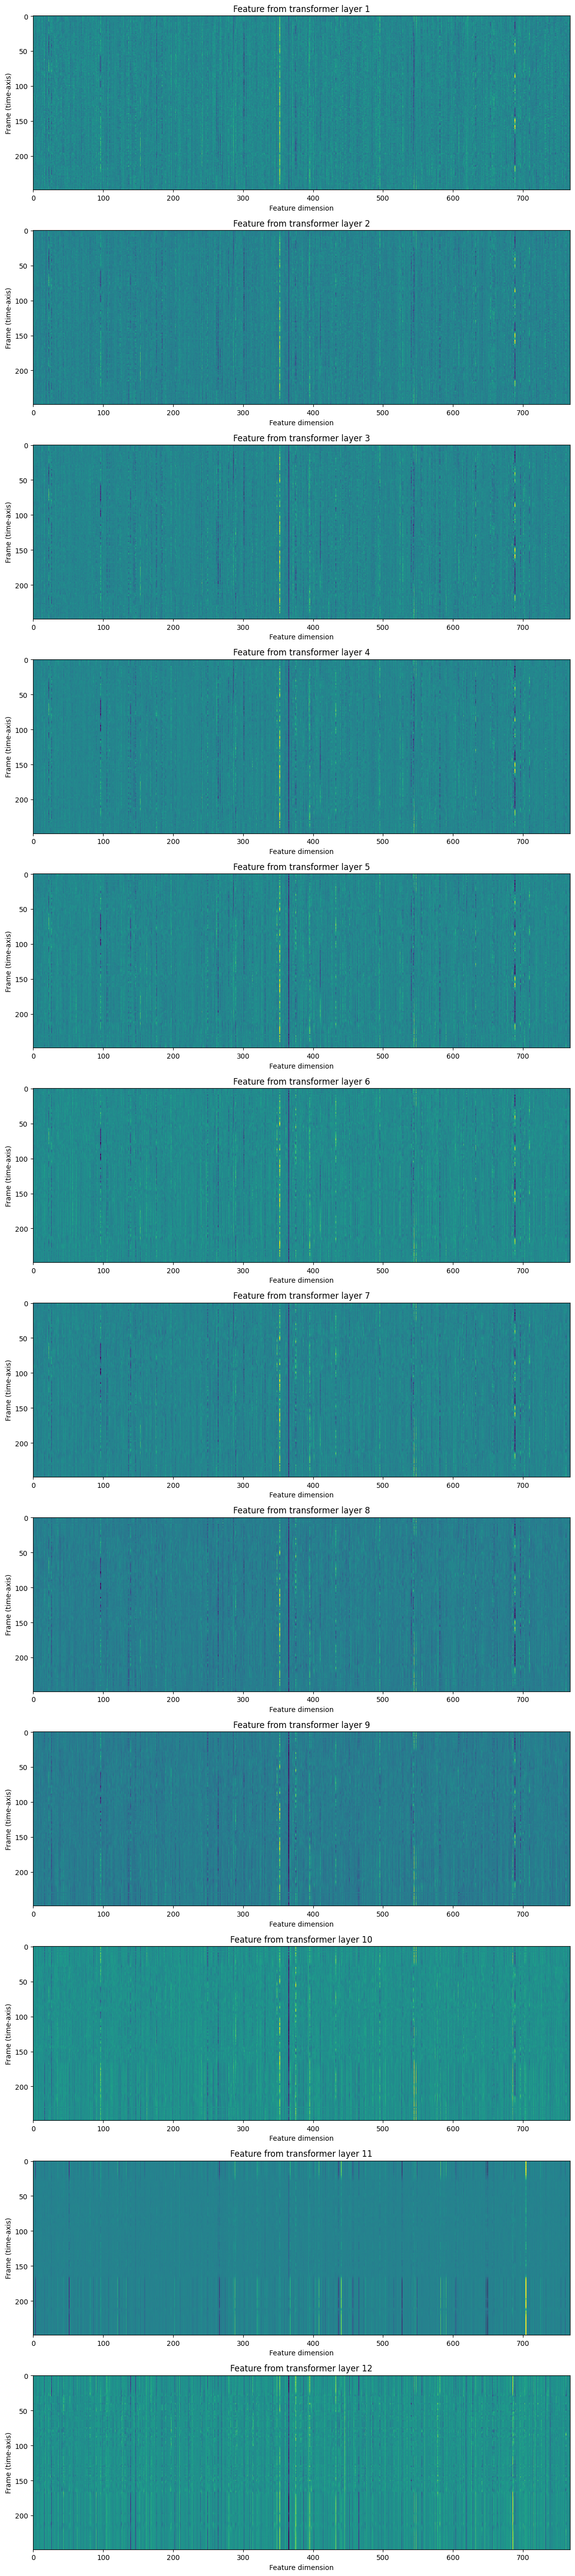

In [67]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [68]:
with torch.inference_mode():
    emission, _ = model(waveform)

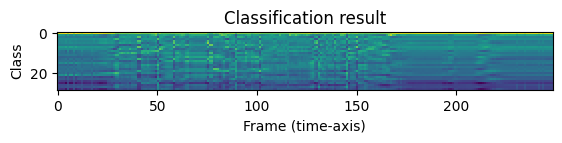

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [69]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [70]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [71]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])
print(transcript)

ON|
